# Object-based Classification of Tree species
### Require packages:
opencv-python, gdal, geopandas, matplotlib, mpl_toolkits, numpy, ogr, pandas, scipy, scikitplot, sklearn, skimage, time
### Implementation steps:
1. Image segmentation
2. Object-based feature extraction
3. Training RF/SVM classifier
4. Assessment of classification results

In [1]:
# Define the working environment
import sys
print('Environment path:',sys.executable)

Environment path: D:\Program Files\ArcGIS\Pro\bin\Python\envs\ge5219\python.exe


In [5]:
import ogr
import gdal
import time
import scipy
import numpy as np
import pandas as pd
import geopandas as gpd

from skimage import exposure
from skimage.feature import peak_local_max
from skimage.segmentation import quickshift, slic, watershed

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


print('Import succesfully!')

Import succesfully!


In [6]:
# Read multi-bands feature image
naip_fn = 'data/features.tif'# The path of input feature image
driverTiff = gdal.GetDriverByName('GTiff') # define image format
naip_ds = gdal.Open(naip_fn) # Load image
nbands = naip_ds.RasterCount # Count the bands
band_data = [] # Initialize band array
print('Input image has',nbands, 'bands.') # Print the number of feature bands

for i in range(1, nbands + 1): # Loop through all bands
    band = naip_ds.GetRasterBand(i).ReadAsArray() # Tranform raster to arrray
    band_data.append(band) # add each band
band_data = np.dstack(band_data) # Tranform gdal image to numpy.array

img = exposure.rescale_intensity(band_data) # Return image after stretching or shrinking its intensity levels

Input image has 40 bands.


## Import MRS segmentation results 

In [7]:
# Load MRS segmentation results
set_scale = 40 # Change segmentation scale
segments_fn = ('data/mrs_seg/mrs_seg_{}.tif').format(set_scale) # Path of MRS segmentation results
segments_ds = gdal.Open(segments_fn) # Open image
segments = segments_ds.GetRasterBand(1).ReadAsArray() # Transform to numpy.array

print('Segmentation image size:', segments.shape) # print(segments.shape) 

Segmentation image size: (2220, 1412)


## Object-based feature extraction
### 1. Function segment_features(segment_pixels)
- **Input:** segmented object (2D array)
- **Output:** object features (1D vector)


In [8]:
# Object-based feature extraction

## Function segment_features(segment_pixels)
## Input: segmented object (2D array)
## Output: object features (1D vector)

### Calculate mean, max, skewness, kurtoisis, std of each object from feature image
def segment_features(segment_pixels): # extract object-based features
    features = [] # Initialize feature
    npixels, nbands = segment_pixels.shape # Calculate pixels and bands
    for b in range(nbands): # Loop through every bands
        stats = scipy.stats.describe(segment_pixels[:, b]) # Calculate statistics of each objects
        band_stats = list(stats.minmax) + list(stats)[2:]  # Save the features to list
        # print(band_stats) 
        if npixels == 1: 
            # in this case the variance = nan, change it 0.0
            band_stats[3] = 0.0 # if the object only contains one pixel, then set the statistics as 0.0
        features += band_stats # add each bands featurs into one list
    return features # return list of features


### 2. Save Object-based feature to csv

In [10]:
# Create Objects
obj_start = time.time() # record start time of Objects creation
segment_ids = np.unique(segments) # Extraction unique values of segments
objects = [] # Create list to save objects
object_ids = [] # Create list ot save objects' id

# Creat dataframe to save object features
df_obj = pd.DataFrame() # Create data frame to save object-based features

for id in segment_ids: # Loop through all the objects
    segment_pixels = band_data[segments == id] # Extract pixels in idth object
    # print('pixels for id', id, segment_pixels.shape) 
    object_features = segment_features(segment_pixels) # Calculate idth object's features
    objects.append(object_features) # Add idth object's features to list
    object_ids.append(id) # Add object id
    # Save object features into df
    df_obj = pd.concat([df_obj, pd.DataFrame(object_features)], axis=1)

# Add column name   
df_obj.columns = [f'object{i}' for i in range(1, 1 + segment_ids.shape[0])] 

# Print number ofobjects and features
print('created', len(objects), 'objects with', len(objects[0]), 'variables in', time.time()-obj_start, 'seconds') 

created 387 objects with 240 variables in 20.049100875854492 seconds


In [405]:
# Remove nan, inf in dataframe
df_obj.replace([np.inf, -np.inf], np.nan) # Replace all inf to nan
df_obj = df_obj.fillna(0) # Change all nan to 0
df_obj.dropna(inplace=True) # Drop all nan value

# Show first 5 lines of data
df_obj.head()

,object1,object2,object3,object4,object5,object6,object7,object8,object9,object10,...,object201,object202,object203,object204,object205,object206,object207,object208,object209,object210
0,57.234375,74.437500,175.0,0.984375,11.437500,15.000000,6.234375,0.000000,12.437500,3.750000,...,73.750000,111.0,224.359375,0.984375,4.609375,53.484375,48.937500,89.750000,136.000000,81.109375
1,157.750000,186.984375,175.0,324.937500,333.750000,477.109375,374.609375,472.437500,329.484375,247.984375,...,260.234375,111.0,224.359375,532.484375,580.109375,53.484375,104.734375,270.484375,256.000000,344.437500
2,103.453125,133.534042,175.0,121.355797,128.309692,162.744888,170.980515,126.590599,100.294106,41.216217,...,142.953125,111.0,224.359375,185.982697,160.931213,53.484375,82.150002,188.286270,206.164062,221.783615
3,1475.811523,847.917908,0.0,5908.016602,2648.895020,5088.561035,3777.705078,4945.667969,1609.724121,949.203308,...,3154.072754,0.0,0.000000,8101.614258,13872.788086,0.000000,509.704529,2203.558594,1695.769653,4566.111328
4,0.228445,-0.040356,0.0,0.119211,0.775367,0.325532,0.121776,0.921039,0.726093,1.794064,...,0.787297,0.0,0.000000,0.446259,0.827735,0.000000,-0.582422,-0.193714,-0.169443,0.190251


In [406]:
# Save the object features to csv
df_obj.to_csv(('data/0413/object_feature_{}.csv').format(set_scale), index=False)

### 3. Visualization of object-based features

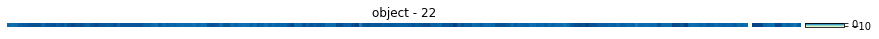

In [407]:
# Visualization of object-based features
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_pixel(pixel, n):
    ax = plt.gca()
    im = ax.imshow(pixel.reshape(1, df_obj.shape[1]), cmap = 'GnBu')# !!! Change the reshape size when change segmented objects，
    plt.title(f'object - {n}') # Set title
    plt.axis('off') # no axis
    divider = make_axes_locatable(ax) # takes an existing axes, adds it to a new AxesDivider and returns the AxesDivider
    cax = divider.append_axes("right", size="5%", pad=0.05) # Set axes parameters
    plt.colorbar(im, cax=cax) # Plot colobar figure
    plt.show() # Display figures
plt.figure(figsize=(15, 10)) # Set figure size

rand_n = np.random.randint(df_obj.shape[0])# Set a random object

plot_pixel(df_obj.iloc[rand_n, :].values, rand_n) # Plot visualization of random object features

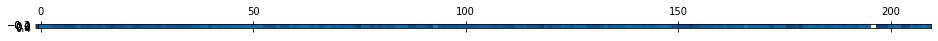

In [408]:
plt.matshow(df_obj.iloc[rand_n, :].values.reshape(1,df_obj.shape[1]), cmap='GnBu') # plot visualization of feature vector

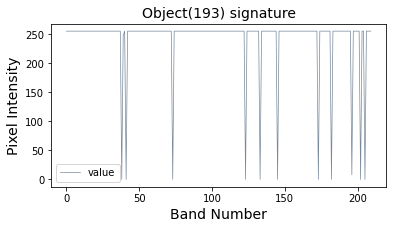

In [409]:
import cv2
import skimage.io
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Visualization of object signature

def plot_signature(df):
    plt.figure(figsize=(6, 3)) # Set figure size 
    object_no = np.random.randint(df_obj.shape[0]) # Pixel number
    plt.plot(range(0, df.shape[1]), df.iloc[object_no,:].values.tolist(), color='lightslategrey', linewidth='0.7',label= f'value') # Plo signature
    plt.legend() # Set legend
    
    plt.title(f'Object({object_no}) signature', fontsize=14 ) # Set title
    plt.xlabel('Band Number', fontsize=14) # Set xlabel
    plt.ylabel('Pixel Intensity', fontsize=14) # Set ylabel
    plt.show() # Show plot
    
plot_signature(df_obj) # Plot object signature

## Training the classifier

### 1. Prepare training groud truth points

In [478]:
# Load and Rasterize train dataset
train_fn = 'data/ground_truth/train.shp' # Path to training shapefile
train_ds = ogr.Open(train_fn) # Open training data
lyr = train_ds.GetLayer() # Tranform training data to layer
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM') # Create a new raster layer in memory
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16) # Create empty raster
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())# Get input fature image
target_ds.SetProjection(naip_ds.GetProjection()) # Set projection
# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options) # Create reaster layer

# Tranform training data to array
ground_truth = target_ds.GetRasterBand(1).ReadAsArray() # Use array as the inputs to train classifier

### 2. Prepare training objects

In [479]:
# get unique values (0 is the background, or no data, value so it is not included) for each land cover type
classes = np.unique(ground_truth)[1:]

# for each class (land cover type) record the associated segment IDs
segments_per_class = {}
for klass in classes: # Loop through all classes
    segments_of_class = segments[ground_truth == klass] 
    segments_per_class[klass] = set(segments_of_class)


In [480]:
# Prepare training objects
train_img = np.copy(segments) # Copy segmented objects image
threshold = train_img.max() + 1 # Set threshold

for klass in classes: # Loop through all tree classes
    class_label = threshold + klass # Save labels
    for segment_id in segments_per_class[klass]: # if object belongs to one class
        train_img[train_img == segment_id] = class_label # assign the class_label to the object in training image

train_img[train_img <= threshold] = 0 # Set non training objects as 0
train_img[train_img > threshold] -= threshold # 

training_objects = [] # Training objects
training_labels = [] # Labels of training objects

for klass in classes:
    # For each objects if the segment ID for that object is in the segments representing the train data in that class
    # Then we will get the values for that segment to use as a training object
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object) # a new list that has times the segments
    training_objects += class_train_object # keep adding those to the training objects
    print("Training objects for class", klass, ":" , len(class_train_object)) # Print out the number of training objects in each class
    

Training objects for class 1 : 42
Training objects for class 2 : 44
Training objects for class 3 : 39
Training objects for class 4 : 23
Training objects for class 5 : 17
Training objects for class 6 : 16
Training objects for class 7 : 13
Training objects for class 8 : 14


In [481]:
# Check nan, inf in training object features
print('Check nan,inf in training object array:')
training_objects = np.array(training_objects)
# training_objects.dtype = 'float64'
training_objects = np.nan_to_num(training_objects) # Transform nan to 0
print('If nan exists:',np.isnan(training_objects).any())
print('If inf exists:',np.isinf(training_objects).any(),'\n') 

# Check nan,inf in all object features
print('Check nan,inf in object array:') # print
objects = np.array(objects) # change to array
#objects[np.isnan(objects)] = 0
objects.dtype = 'float32' # change type
objects = np.nan_to_num(objects) # replace nan
print('If nan exists:',np.isnan(objects).any()) # check if nan exists
print('If inf exists:',np.isinf(objects).any()) # check if inf exists


Check nan,inf in training object array:
If nan exists: False
If inf exists: False 

Check nan,inf in object array:
If nan exists: False
If inf exists: False


## Random Forest Classification 

### 3. Train RF classifier
- **Input:** training data, training label
- **Output:** predicted labels

In [514]:
# import RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

classifier = RandomForestClassifier(n_estimators=120, max_depth=80,n_jobs=-1,min_samples_leaf=1, max_features="log2") # RandomForest Classifier

# Train the RF Classifier
print('Start fitting Random Forest Classifier...')
start_time = time.time()
classifier.fit(training_objects, training_labels)
end_time = time.time()
print('Fitting complete!\n')
print('Training RF costs',end_time-start_time,'seconds.\n')


Start fitting Random Forest Classifier...
Fitting complete!

Training RF costs 0.26302528381347656 seconds.



In [515]:
print('Predicting Classifications...')
# Predict all the object labels
predicted = classifier.predict(objects)
print('Predicting complete!')

Predicting Classifications...
Predicting complete!


In [516]:
# Summarize feature importance
importance = classifier.feature_importances_

for i,v in enumerate(importance): # Loop through all importance
    print('Feature: %0d, Score: %.5f' % (i,v)) # print out the importance of each features

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00422
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00331
Feature: 4, Score: 0.00058
Feature: 5, Score: 0.00240
Feature: 6, Score: 0.00114
Feature: 7, Score: 0.00239
Feature: 8, Score: 0.00099
Feature: 9, Score: 0.00432
Feature: 10, Score: 0.00201
Feature: 11, Score: 0.00335
Feature: 12, Score: 0.00047
Feature: 13, Score: 0.00438
Feature: 14, Score: 0.00119
Feature: 15, Score: 0.00523
Feature: 16, Score: 0.00056
Feature: 17, Score: 0.00298
Feature: 18, Score: 0.00100
Feature: 19, Score: 0.00534
Feature: 20, Score: 0.00083
Feature: 21, Score: 0.00229
Feature: 22, Score: 0.00219
Feature: 23, Score: 0.00324
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00132
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00300
Feature: 28, Score: 0.00094
Feature: 29, Score: 0.00261
Feature: 30, Score: 0.00181
Feature: 31, Score: 0.00518
Feature: 32, Score: 0.00090
Feature: 33, Score: 0.00305
Feature: 34, Score: 0.00153
Feature: 35, Score: 0.00237
Fe

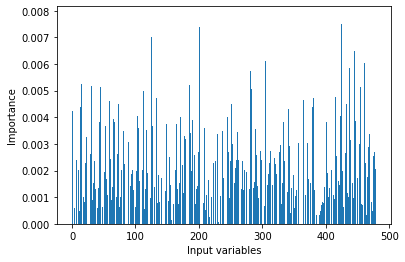

In [517]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance, align='center', orientation='vertical') # Plot bar 
plt.ylabel("Importance") # Set ylabel
plt.xlabel("Input variables")# Set xlabel
plt.show()# Show plot importance of input variables in RF classifier

### 4. Save RF classified results

In [518]:

clf = np.copy(segments) # Copy segmented image
# Link the segment ID to the predicted values
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass # Create classification image array
# Make a mask to exlude nodata
mask = np.sum(img, axis=2) 
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0

clf = np.multiply(clf, mask) # Apply mask to classification image
clf[clf < 0] = -9999.0 # Set NoData Value

# Save Classified Results
clf_ds = driverTiff.Create(('results/rf_classified_image_{}.tif').format(set_scale), naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_Float32)
clf_ds.SetGeoTransform(naip_ds.GetGeoTransform()) # Transform
clf_ds.SetProjection(naip_ds.GetProjection())# Set Projection
clf_ds.GetRasterBand(1).SetNoDataValue(-9999.0)# Set nodata value
clf_ds.GetRasterBand(1).WriteArray(clf)# Save to raster
clf_ds = None

print('RF Classification Done!') 

RF Classification Done!


### 5. Assessment of classification accuracy

In [519]:
from sklearn import metrics # import evaluation metrics
 
# Import test data
# Rasterize test data for pixel-to-pixel comparison
test_fn = 'data/ground_truth/test.shp' # Path to test data
test_ds = ogr.Open(test_fn) # Opent test data
lyr = test_ds.GetLayer() # As layer
driver = gdal.GetDriverByName('MEM') # Create raster in memeory
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform()) # Copy geo info
target_ds.SetProjection(naip_ds.GetProjection()) # Set projection
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options) # Create raster layer for test data
 
truth = target_ds.GetRasterBand(1).ReadAsArray()  # truth/test data array
 
pred_ds = gdal.Open(('results/rf_classified_image_{}.tif').format(set_scale)) # open classified image

pred = pred_ds.GetRasterBand(1).ReadAsArray()  # predicted data array
idx = np.nonzero(truth) # get indices where truth/test has data values
cm = metrics.confusion_matrix(truth[idx], pred[idx])  # create a confusion matrix at the truth/test locations
 
# pixel accuracy
print(cm) # print out confusion matrix
print(cm.diagonal()) # The diagonal values of confusion matrix

[[45  6  4  0  4  5  0  0]
 [ 6 29  9  0  2  0  4  0]
 [ 6  5 59  0  1  0 13  1]
 [15  1  1  7  1  0  1  0]
 [ 7  4  4  0  9  0  0  0]
 [ 6  1  1  0  0 19  1  0]
 [11  1  0  0  0  0  3  0]
 [ 4  0  1  0  0  0  0  3]]
[45 29 59  7  9 19  3  3]


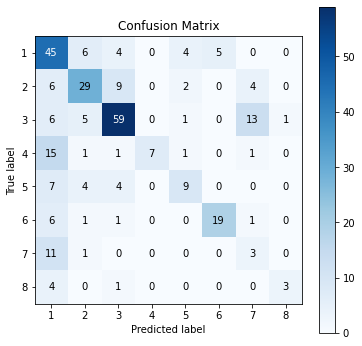

In [520]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    truth[idx], 
    pred[idx],
    figsize=(6,6))

plt.savefig('results/rf_cm.png')

In [521]:
# Plot accuracy report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('RF Classification report:\n',classification_report(truth[idx], pred[idx]))
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(truth[idx], pred[idx])
print('kappa:',kappa)

RF Classification report:
               precision    recall  f1-score   support

           1       0.45      0.70      0.55        64
           2       0.62      0.58      0.60        50
           3       0.75      0.69      0.72        85
           4       1.00      0.27      0.42        26
           5       0.53      0.38      0.44        24
           6       0.79      0.68      0.73        28
           7       0.14      0.20      0.16        15
           8       0.75      0.38      0.50         8

    accuracy                           0.58       300
   macro avg       0.63      0.48      0.52       300
weighted avg       0.64      0.58      0.58       300

kappa: 0.4815597097831603


In [522]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(truth[idx], pred[idx])
print('kappa:',kappa)

kappa: 0.4815597097831603


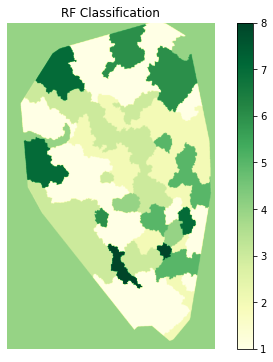

In [523]:
# Plot classification image
plt.figure(figsize=(8, 6)) # set plot size
plt.imshow(pred, cmap='YlGn')# show classification image
plt.colorbar() # set colorbar
plt.axis('off') # close axis
plt.title('RF Classification') # set title
plt.savefig('results/RF_Classification.png') # save figure
plt.show() # show plot

## SVM classification 
### Train SVM classifier

In [540]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf',degree = 5, C=10, gamma=0.001) # set SVM parameters

start_time=time.time() # record start time
print('Fitting SVM Classifier...') # print start training

svm.fit(training_objects, training_labels) # train SVM

end_time = time.time() # record end time
print('Fitting complete!\n')
print('Training SVM costs',end_time-start_time,'seconds.\n') # print cost of time


Fitting SVM Classifier...
Fitting complete!

Training SVM costs 0.014466285705566406 seconds.



In [541]:
print('Predicting Classifications...')
# Predict all the object labels
predicted = svm.predict(objects)
print('Predicting complete!')

Predicting Classifications...
Predicting complete!


### Save SVM  classified results 

In [542]:
clf = np.copy(segments) # Copy segmented image
# Link the segment ID to the predicted values
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass # Create classification image array
# Make a mask to exlude nodata
mask = np.sum(img, axis=2) 
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0

clf = np.multiply(clf, mask) # Apply mask to classification image
clf[clf < 0] = -9999.0 # Set NoData Value

# Save Classified Results
clf_ds = driverTiff.Create(('results/svm_classified_image_{}.tif').format(set_scale), naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_Float32)
clf_ds.SetGeoTransform(naip_ds.GetGeoTransform()) # Transform
clf_ds.SetProjection(naip_ds.GetProjection())# Set Projection
clf_ds.GetRasterBand(1).SetNoDataValue(-9999.0)# Set nodata value
clf_ds.GetRasterBand(1).WriteArray(clf)# Save to raster
clf_ds = None

print('SVM Classification Done!') 

SVM Classification Done!


### Assessment of classification accuracy

Confusion matrix:
 [[44 18  1  0  0  1  0  0]
 [ 1 45  4  0  0  0  0  0]
 [ 3 31 51  0  0  0  0  0]
 [ 5 16  0  5  0  0  0  0]
 [ 1 20  0  1  2  0  0  0]
 [13  3  0  0  0 12  0  0]
 [ 2 11  0  0  0  0  2  0]
 [ 1  4  0  0  0  0  0  3]] 

Diagonal of confusion matrix:
 [44 45 51  5  2 12  2  3] 

SVM Classification report:
               precision    recall  f1-score   support

           1       0.63      0.69      0.66        64
           2       0.30      0.90      0.45        50
           3       0.91      0.60      0.72        85
           4       0.83      0.19      0.31        26
           5       1.00      0.08      0.15        24
           6       0.92      0.43      0.59        28
           7       1.00      0.13      0.24        15
           8       1.00      0.38      0.55         8

    accuracy                           0.55       300
   macro avg       0.82      0.43      0.46       300
weighted avg       0.76      0.55      0.54       300

kappa: 0.439082735296543

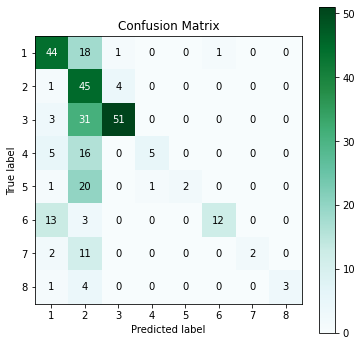

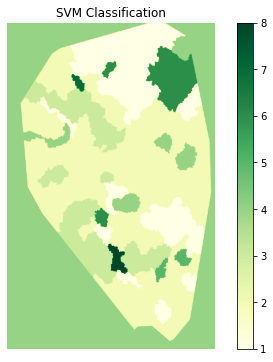

In [543]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics # import evaluation metrics
import scikitplot as skplt
# Import test data
# Rasterize test data for pixel-to-pixel comparison
test_fn = 'data/ground_truth/test.shp' # Path to test data
test_ds = ogr.Open(test_fn) # Opent test data
lyr = test_ds.GetLayer() # As layer
driver = gdal.GetDriverByName('MEM') # Create raster in memeory
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform()) # Copy geo info
target_ds.SetProjection(naip_ds.GetProjection()) # Set projection
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options) # Create raster layer for test data
 
truth = target_ds.GetRasterBand(1).ReadAsArray()  # truth/test data array
 
pred_ds = gdal.Open(('results/svm_classified_image_{}.tif').format(set_scale)) # open classified image
pred = pred_ds.GetRasterBand(1).ReadAsArray()  # predicted data array
idx = np.nonzero(truth) # get indices where truth/test has data values
cm = metrics.confusion_matrix(truth[idx], pred[idx])  # create a confusion matrix at the truth/test locations
 
# pixel accuracy
print('Confusion matrix:\n',cm,'\n') # print out confusion matrix
print('Diagonal of confusion matrix:\n',cm.diagonal(),'\n') # The diagonal values of confusion matrix

# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(
    truth[idx], 
    pred[idx],
    figsize=(6,6), cmap='BuGn')

# Plot accuracy report
print('SVM Classification report:\n',classification_report(truth[idx], pred[idx]))

kappa = cohen_kappa_score(truth[idx], pred[idx])
print('kappa:',kappa)

# Plot classification image
plt.figure(figsize=(8, 6)) # set plot size
plt.imshow(pred, cmap='YlGn')# show classification image
plt.colorbar() # set colorbar
plt.axis('off') # close axis
plt.title('SVM Classification') # set title
plt.savefig('SVM_Classification.png') # save figure
plt.show() # show plot